# EE-25620: Deep Learning

**توضیحات**

در این نوتبوک میخواهیم یک شبکه خواسته شده را با تنسورفلوی یک پیاده سازی کنیم.

معماری شبکه را به همان صورتی که در صورت سوال خواسته شده است چیده ام. در قسمت اول باید بر روی دیتاست اول این شبکه را آموزش دهیم. با همین معماری دقت تست من به 55 می رسید که باید طبق صورت سوال بالاتر باشد. با توجه به این من از ترمهای رگولاریزیشن استفاده کردم به صورتی که با ضریب های کوچک حدوداً 0.01 از رگولاریزیشن ال درجه 2 از وزنهای لایه های آخر و یک لایه وسط را به تابع تلف خود اضافه کردم که دقت تست را به حدوداً 62 درصد رساند. هم چنین به نوعی با تنظیم کردن تعداد ایپاک ها از اورفیتینگ جلوگیری کردم چون در ایپاک های بالاتر به سمت اورفیتینگ میرفت.

حال همان وزن ها را فریز کردیم و در قسمت آخر که ترنسفر لرنینگ است استفاده کردم اما به خواسته سوال که دقت 80 درصد بود نرسیدم حتی با اینکه ترکیبی از رنج مختلف ضرایب و هر دو وزن مختلف لایه های مورد یادگیری را برای رگولاریزیشن استفاده کردم، به تغییر خاصی نرسیدم و از آنجا که معماری خواسته شده را فقط باید پیاده سازی میکردیم ایده دیگری غیر از تغییر نوع آپتیمایزرها و یا تغییر لرنینگ ریت نداشتم که آن ها هم به طور کلی تغییر خاصی ایجاد نمیکردند. و در نهایت دقت تست من به حدود 72.5 درصد رسید.

 # HW3.CNN on CIFAR (20 + 10 points)

In this problem, we will train a CNN on CIFAR-10 database. Next, we will go through the network and visualize its layers to see what is happening there. Then, we use the trained model in a Transfer Learning approach to classifying the CIFAR-100 database.

Let's start with loading data. First load the data by runing the code below:

In [ ]:
%tensorflow_version 1.x

In [ ]:
from load_data import load_cifar10 #this function provided in the attached file loads the data of CIFAR10 database

def load_cifar10_data():
    dataset_dir = 'cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_cifar10(dataset_dir)
    X_train, X_val = X_train[:45000], X_train[45000:]
    y_train, y_val = y_train[:45000], y_train[45000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


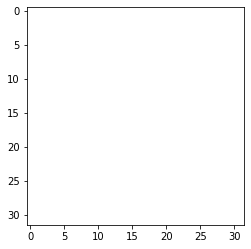

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[1])#represnting a sample data from CIFAR-10
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-10.

The below code will convert the labels to one-hot codes which will be later used for the classification.

In [ ]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(y_train)#this line will fit 'encoder' to encode the labels

y_train_onehot = encoder.transform(y_train)# encoding train labels (one-hot coding)
y_val_onehot   = encoder.transform(y_val)  # encoding train labels (one-hot coding)
y_test_onehot  = encoder.transform(y_test) # encoding test  labels (one-hot coding)

The function below is for converting data to several batches which we will use in training.

In [ ]:
def make_batches(x, y, batch_size):
    n = len(y)
    steps = n // batch_size
    if n % batch_size != 0:
        steps += 1
    x_batches = np.array_split(x, steps)
    y_batches = np.array_split(y, steps)
    return x_batches, y_batches

## Part1: Trainig a CNN (15 pts.)

In this part, we are going to train a Convolutional Neural Network (CNN) with the below structure:

1. 16 * conv(5,5), activation function =ReLU
2. 16 * conv(5,5), activation function =ReLU
3. Max-pooling(3,3), stride=(2,2)
4. 32 * conv(5,5), activation function =ReLU
5. 32 * conv(5,5), activation function =ReLU
6. Max-pooling(3,3), stride=(2,2)
7. 64 * conv(5,5), activation function =ReLU
8. FC(128), activation function =ReLU
9. FC(128), activation function =ReLU
10. FC(10), activation function =softmax

Let's go to implement the model in the below box. Note that using **tf.layers** is **NOT ALLOWED** in this homework.

In [ ]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y = tf.placeholder(tf.float32, [None, 10])# placeholder for labels (one-hot encoded)


W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 16],mean=0,stddev=0.01))
B_conv1 = tf.Variable(tf.truncated_normal(shape=[16],mean=0,stddev=0.01))

conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + B_conv1
conv1_relu = tf.nn.relu(conv1)

W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 16, 16],mean=0,stddev=0.01))
B_conv2 = tf.Variable(tf.truncated_normal(shape=[16],mean=0,stddev=0.01))

conv2 = tf.nn.conv2d(conv1_relu, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + B_conv2
conv2_relu = tf.nn.relu(conv2)

pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')


W_conv3 = tf.Variable(tf.truncated_normal(shape=[5, 5, 16, 32],mean=0,stddev=0.01))
B_conv3 = tf.Variable(tf.truncated_normal(shape=[32],mean=0,stddev=0.01))

conv3 = tf.nn.conv2d(pooling1, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + B_conv3
conv3_relu = tf.nn.relu(conv3)

W_conv4 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 32],mean=0,stddev=0.01))
B_conv4 = tf.Variable(tf.truncated_normal(shape=[32],mean=0,stddev=0.01))

conv4 = tf.nn.conv2d(conv3_relu, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + B_conv4
conv4_relu = tf.nn.relu(conv4)

pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv5 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64],mean=0,stddev=0.01))
B_conv5 = tf.Variable(tf.truncated_normal(shape=[64],mean=0,stddev=0.01))

conv5 = tf.nn.conv2d(pooling2, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + B_conv5
conv5_relu = tf.nn.relu(conv5)

layer_flat = tf.reshape(conv5_relu, [-1, 8*8*64])

W_hidden1 = tf.Variable(tf.truncated_normal(shape=[64*64,128],mean=0,stddev=0.01))
B_hidden1 = tf.Variable(tf.truncated_normal(shape=[128],mean=0,stddev=0.01))

hidden1 = tf.nn.relu(tf.matmul(layer_flat, W_hidden1) + B_hidden1)

W_hidden2 = tf.Variable(tf.truncated_normal(shape=[128,128],mean=0,stddev=0.01))
B_hidden2 = tf.Variable(tf.truncated_normal(shape=[128],mean=0,stddev=0.01))

hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden2) + B_hidden2)

W_final = tf.Variable(tf.truncated_normal(shape=[128,10],mean=0,stddev=0.01))
B_final = tf.Variable(tf.truncated_normal(shape=[10],mean=0,stddev=0.01))

#logits = tf.contrib.layers.fully_connected(inputs=hidden2, num_outputs=10, activation_fn=None)
logits = tf.matmul(hidden2, W_final) + B_final
y_hat = tf.nn.softmax(logits)


Now you need to define an optimizer. You are free to use any optimizer. You can change optimizer or learning rate if you want :)

In [ ]:
############ Cross entropy loss ############################
regularizer = 0.01*(tf.nn.l2_loss(W_final)) + 0.005*(tf.nn.l2_loss(W_hidden2)) + 0.01*(tf.nn.l2_loss(W_hidden1)) + 0.002*(tf.nn.l2_loss(W_conv3)) 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)) + regularizer
# Note: logits in the above line is the last layer values (a 10-neuron layer) before the softmax activation function. 
#       In other words, you may have written y_hat = tf.nn.softmax(logits) in the above box in which y_hat is tُhe output
#       of the network.
############ Adam optimizer ################################
lr = 0.0001 # learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
trainer = optimizer.minimize(cross_entropy)

############################################################
#            TODO: Implement Accuracy                      #
############################################################

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
# Note: The defined accuray does not play any role in the optimization process. However, it is a mtric which we can 
#       use as a log for mintoring training process with more metrics rather than a single loss function.
############################################################

You can go for the rest of the job, handle the Session and go for training. 
You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data.
You are expected to achieve at least 60% accuracy on the test data after the training process. Good Luck! ;)

In [ ]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(X_train, y_train_onehot, batch_size)
epochs = 16  # You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

#sess = tf.Session() 
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for epoch in range(epochs):
        print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([trainer, accuracy, cross_entropy],{x: x_train_batches[n], y: y_train_batches[n]})
            #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([accuracy, cross_entropy],
                                                   {x: X_val, y: y_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
      
  test_acc, test_loss = sess.run([accuracy, cross_entropy],
                                    {x: X_test, y: y_test_onehot})
  tfSaver = tf.train.Saver()
  tfSaver.save(sess, "my_session/")
  sess.close()
    
print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))

############################################################

********** Epoch   0 **********
Train:		Accuracy= 0.2447 	Loss= 2.0473
Validation:	Accuracy= 0.2876 	Loss= 1.8998
********** Epoch   1 **********
Train:		Accuracy= 0.3361 	Loss= 1.8095
Validation:	Accuracy= 0.3434 	Loss= 1.7568
********** Epoch   2 **********
Train:		Accuracy= 0.3835 	Loss= 1.6815
Validation:	Accuracy= 0.4034 	Loss= 1.6400
********** Epoch   3 **********
Train:		Accuracy= 0.4334 	Loss= 1.5653
Validation:	Accuracy= 0.4664 	Loss= 1.4978
********** Epoch   4 **********
Train:		Accuracy= 0.4701 	Loss= 1.4802
Validation:	Accuracy= 0.4898 	Loss= 1.4331
********** Epoch   5 **********
Train:		Accuracy= 0.4949 	Loss= 1.4196
Validation:	Accuracy= 0.5098 	Loss= 1.3788
********** Epoch   6 **********
Train:		Accuracy= 0.5173 	Loss= 1.3688
Validation:	Accuracy= 0.5304 	Loss= 1.3408
********** Epoch   7 **********
Train:		Accuracy= 0.5364 	Loss= 1.3228
Validation:	Accuracy= 0.5508 	Loss= 1.3032
********** Epoch   8 **********
Train:		Accuracy= 0.5580 	Loss= 1.2775
Validation:	Accur

### Training Diagram

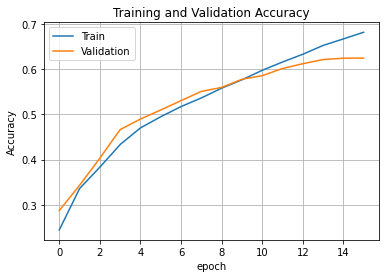

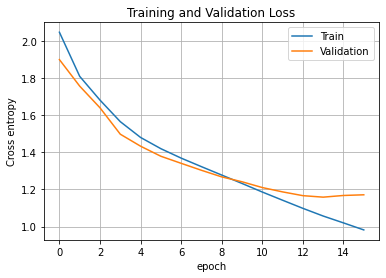

In [ ]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

## Part2: Visualizing the Network (5 pts.)

Now, we want to check the weights to see how the network realy works and what it does. Consider the wieghts of the first convolutional layer, find its weights values and print the values of 2 arbitrary filters:

In [ ]:
##########################################################################
# TODO                                                                   #
# Note: To retrieve the values of the weight-variables from TensorFlow,  #
#       feed-dict is not necessary because                               #
#       nothing is calculated.                                           #
#       e.g., w = sess.run(weights)                                      #
##########################################################################

sess = tf.InteractiveSession()

# then write the saved session on 'sess'
tfSaver.restore(sess, "my_session/")

w = sess.run(W_conv1)

print(w[:,:,0,0])
print(w[:,:,0,10]) 
##########################################################################

INFO:tensorflow:Restoring parameters from my_session/


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[ 0.01147486  0.00759288  0.01183594 -0.01042215 -0.00817614]
 [ 0.00420677  0.02449917  0.00897912  0.00386233 -0.01210316]
 [ 0.00630507  0.02833628  0.0162365   0.01834138  0.00331085]
 [-0.00387044 -0.00762618  0.00730176  0.00043215  0.00665383]
 [-0.00289328 -0.00212481 -0.02659025 -0.02397149 -0.01154133]]
[[ 0.0209308  -0.00759886 -0.02555302 -0.02476566 -0.01550448]
 [ 0.01402337  0.00863983 -0.01449464  0.00265243  0.00423913]
 [-0.01449327  0.02352502  0.02973162  0.04073063  0.00724797]
 [ 0.00226317  0.01471876  0.03761893  0.04645034  0.02162037]
 [-0.00161988  0.00453825 -0.00785589  0.01444353  0.02527639]]


### Question: Try to interpret what they are doing?

### Answer: 

در اینجا مقادیر وزن های یادگیری شده را پرینت کردیم برای دو فیلتر مختلف در دو کانال مختلف،

مثلا در قسمت اولی از لبه های پایین به صورت تفاضلی نمونه برداری شده است و بقیه مقادیر در اکثر جاها کم است

یا در فیلتر بعدی این مقادیر برای بالای سمت راست بیشتر هستند.

به طور کلی فیلترهای مختلف از لبه های مختلف نمونه برداری میکنند.

Now let's visualize the filters of the first conv layer. There are lots of ways to code for visualization. You are free to choose any way you want. However below is function which is provided for you to plot the weights.

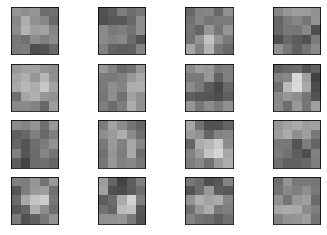

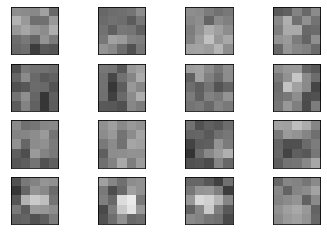

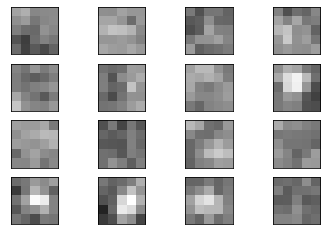

In [ ]:
import math
def plot_conv_weights(w, input_channel=0):
    # The argument w is a 4-dim array.(e.g. weights_conv1 with the shape of [5,5,3,64])
    # The argument input_channel shows the specified channel of all filters.
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='gray')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    
##########################################################################
# TODO: call the function above or use your own way here                 #
##########################################################################
plot_conv_weights(w,0)
plot_conv_weights(w,1)
plot_conv_weights(w,2)

##########################################################################


### Question: Try to interpret what they are doing?

### Answer: 

در اینجا نیز کرنل های 5 در 5 هر سه کانال که 16 تا هستند را به تصویر کشیده ام، همانطور که در قسمت قبل گفتم، هر یک از این فیلترها از لبه های مختلفی نمونه بردای میکنند که با رنگ سیاهتر مشخص است.

## Part3: Transfer Learning (+10 pts. - optional)

In all the machine learning problems we need data to train our models. However, the volume of the data might not be sufficient for the considered model. In such cases, we may use a model which is trained on a similar dataset probably for a different objective. Then we transfer to the main problem and fine- tune or replace some parts of the network. 

In this exercise, we are going to implement the transfer learning concept on CNN. For this purpose, we use the network that you have trained on Part 1 of this homework (above) to classify three new classes (i.e. bee, elephant, and fox) on CIFAR-100 dataset. Let's first load the data:

In [ ]:
from load_data import load_cifar100 #this function provided in the attached file loads the data of CIFAR100 database

def load_cifar100_data():
    dataset_dir = 'cifar-100-python'
    
    X_train, y_train, X_test, y_test = load_cifar100(dataset_dir)
    
    return X_train, y_train, X_test, y_test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


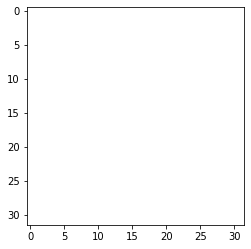

In [ ]:
X_train, y_train, X_test, y_test = load_cifar100_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[1])#represnting a sample data from CIFAR-100
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-100. The below code will seprate the specified classes (i.e. bee(6), elephant(31), and fox(34)) for the new classification problem.

In [ ]:
selected_images_train = np.zeros([1,32,32,3])
selected_labels_train = np.zeros([1,1])
for i in range(50000):
    label = y_train[i]
    if label==6 or label==31 or label==34:
        selected_images_train = np.append(selected_images_train,np.reshape(X_train[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_train = np.append(selected_labels_train,np.reshape(label,[1,1]),axis=0)
selected_images_train = selected_images_train[1:]# to remove the first defined np..zeros data
selected_labels_train = selected_labels_train[1:]# to remove the first defined np..zeros data


selected_images_test = np.zeros([1,32,32,3])
selected_labels_test = np.zeros([1,1])
for i in range(10000):
    label = y_test[i]
    if label==6 or label==31 or label==34:
        selected_images_test = np.append(selected_images_test,np.reshape(X_test[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_test = np.append(selected_labels_test,np.reshape(label,[1,1]),axis=0)
selected_images_test = selected_images_test[1:]# to remove the first defined np..zeros data
selected_labels_test = selected_labels_test[1:]# to remove the first defined np..zeros data

In [ ]:
images_train = selected_images_train[:int(selected_images_train.shape[0]*0.8),:,:,:]
labels_train = selected_labels_train[:int(selected_images_train.shape[0]*0.8),:]

images_validation = selected_images_train[int(selected_images_train.shape[0]*0.8):,:,:,:]
labels_validation = selected_labels_train[int(selected_images_train.shape[0]*0.8):,:]

images_test = selected_images_test
labels_test = selected_labels_test


print('images_train shape:', images_train.shape)
print('labels_train shape:', labels_train.shape)

print('images_validation shape:', images_validation.shape)
print('labels_validation shape:', labels_validation.shape)

print('images_test shape:', images_test.shape)
print('labels_test shape:', labels_test.shape)

images_train shape: (1200, 32, 32, 3)
labels_train shape: (1200, 1)
images_validation shape: (300, 32, 32, 3)
labels_validation shape: (300, 1)
images_test shape: (300, 32, 32, 3)
labels_test shape: (300, 1)


In [ ]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(selected_labels_train)#this line will fit 'encoder' to encode the labels

labels_train_onehot = encoder.transform(labels_train)# encoding train labels (one-hot coding)
labels_val_onehot   = encoder.transform(labels_validation)  # encoding train labels (one-hot coding)
labels_test_onehot  = encoder.transform(labels_test) # encoding test  labels (one-hot coding)

To implement the transfer learning, we need to use the previous model and transfer it to the new problem. For this end, you need to freeze the convolution layers and also the first fully connected layer which means that they should not be updated in the new training process. For the last two fully connected layers, we want to fine-tune the values. However, you should replace the last layer (output layer) with a 3-neuron layer to represent the score for each class.

There are several methods that you can implement the discussed process with TensorFlow. You are free to do any way you want.
The below code redefine the network and use the weights of the network trained on CIFAR-10. Then, the frozen weights can be defined as either constant or non-trainable variables. Besides, the fine-tuning weights are also defined as variables with their previous weights in the definition. Anyway, since there are other ways to implement this job, you can do it with your own method.

In [ ]:
############################################################
#            TODO: Implement Accuracy Part                 #
############################################################

# get the weights form previous network:
# e.g., w_conv1_CIFAR10 = sess.run(W_conv1)
w1 = sess.run(W_conv1)
b1 = sess.run(B_conv1)

w2 = sess.run(W_conv2)
b2 = sess.run(B_conv2)

w3 = sess.run(W_conv3)
b3 = sess.run(B_conv3)

w4 = sess.run(W_conv4)
b4 = sess.run(B_conv4)

w5 = sess.run(W_conv5)
b5 = sess.run(B_conv5)

wh1 = sess.run(W_hidden1)
bh1 = sess.run(B_hidden1)


tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y_new = tf.placeholder(tf.float32, [None, 3])# placeholder for labels (one-hot encoded)

# Re-define the convolutional layers

conv1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='SAME') + b1
conv1_relu = tf.nn.relu(conv1)

conv2 = tf.nn.conv2d(conv1_relu, w2, strides=[1, 1, 1, 1], padding='SAME') + b2
conv2_relu = tf.nn.relu(conv2)

pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

conv3 = tf.nn.conv2d(pooling1, w3, strides=[1, 1, 1, 1], padding='SAME') + b3
conv3_relu = tf.nn.relu(conv3)

conv4 = tf.nn.conv2d(conv3_relu, w4, strides=[1, 1, 1, 1], padding='SAME') + b4
conv4_relu = tf.nn.relu(conv4)

pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

conv5 = tf.nn.conv2d(pooling2, w5, strides=[1, 1, 1, 1], padding='SAME') + b5
conv5_relu = tf.nn.relu(conv5)

layer_flat = tf.reshape(conv5_relu, [-1, 8*8*64])

hidden1 = tf.nn.relu(tf.matmul(layer_flat, wh1) + bh1)

# Define weights for the second FC layer (fc1 is already defined in the previous model)
W_fc2_new = tf.Variable(tf.truncated_normal(shape=[128,128],mean=0,stddev=0.01))
B_fc2_new = tf.Variable(tf.truncated_normal(shape=[128],mean=0,stddev=0.01))
# Define based on the first fully connected layer.
fc2_new = tf.nn.relu(tf.matmul(hidden1, W_fc2_new) + B_fc2_new)
#fc2_new = tf.nn.dropout(fc2_new,0.02)


W_fc3_new = tf.Variable(tf.truncated_normal(shape=[128,3],mean=0,stddev=0.01))
B_fc3_new = tf.Variable(tf.truncated_normal(shape=[3],mean=0,stddev=0.01))
# Define based on the second fully connected layer (fc2_new).
logit = tf.matmul(fc2_new, W_fc3_new) + B_fc3_new

y_hat = tf.nn.softmax(logit)




Now, go for the rest of the job and start training:

In [ ]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(images_train, labels_train_onehot, batch_size)
epochs = 20  # You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

regularizer = 0.01*(tf.nn.l2_loss(W_fc3_new))+0.015*(tf.nn.l2_loss(W_fc2_new))
new_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y_new)) + regularizer

lr = 1e-4
  #AdagradDAOptimizer
new_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
  #new_optimizer = tf.train.FtrlOptimizer(learning_rate=lr,l1_regularization_strength=0.01, l2_regularization_strength=0.009)
new_trainer = new_optimizer.minimize(new_cross_entropy)

correct_preds = tf.equal(tf.argmax(logit, 1), tf.argmax(y_new, 1))
new_accuracy  = tf.reduce_mean(tf.cast(correct_preds, tf.float32), name='accuracy')
with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      for epoch in range(epochs):
          print()
          print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

          batch_acc = np.zeros(N_Batches)
          batch_loss = np.zeros(N_Batches)
          for n in range(N_Batches):

              _, batch_acc[n], batch_loss[n] = sess.run([new_trainer, new_accuracy, new_cross_entropy],
                                                        {x: x_train_batches[n], y_new: y_train_batches[n]})
              #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

          train_acc[epoch] = np.mean(batch_acc)
          train_loss[epoch] = np.mean(batch_loss)
          print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

          ########## Validation ##########
          val_acc[epoch], val_loss[epoch] = sess.run([new_accuracy, new_cross_entropy],
                                                    {x: images_validation, y_new: labels_val_onehot})
          print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
      test_acc, test_loss = sess.run([new_accuracy, new_cross_entropy],
                              {x: images_test, y_new: labels_test_onehot})
print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))
############################################################


********** Epoch   0 **********
Train:		Accuracy= 0.4570 	Loss= 1.0841
Validation:	Accuracy= 0.6267 	Loss= 1.0385

********** Epoch   1 **********
Train:		Accuracy= 0.6159 	Loss= 1.0097
Validation:	Accuracy= 0.6600 	Loss= 0.9612

********** Epoch   2 **********
Train:		Accuracy= 0.6393 	Loss= 0.9379
Validation:	Accuracy= 0.6867 	Loss= 0.8831

********** Epoch   3 **********
Train:		Accuracy= 0.6509 	Loss= 0.8695
Validation:	Accuracy= 0.6933 	Loss= 0.8186

********** Epoch   4 **********
Train:		Accuracy= 0.6618 	Loss= 0.8180
Validation:	Accuracy= 0.6867 	Loss= 0.7748

********** Epoch   5 **********
Train:		Accuracy= 0.6693 	Loss= 0.7815
Validation:	Accuracy= 0.6867 	Loss= 0.7471

********** Epoch   6 **********
Train:		Accuracy= 0.6876 	Loss= 0.7554
Validation:	Accuracy= 0.6867 	Loss= 0.7297

********** Epoch   7 **********
Train:		Accuracy= 0.6951 	Loss= 0.7355
Validation:	Accuracy= 0.6933 	Loss= 0.7181

********** Epoch   8 **********
Train:		Accuracy= 0.6985 	Loss= 0.7193
Validati

You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data. You are expected to achieve at least 80% accuracy on the test data after training. Good Luck! ;)

### Training Diagram

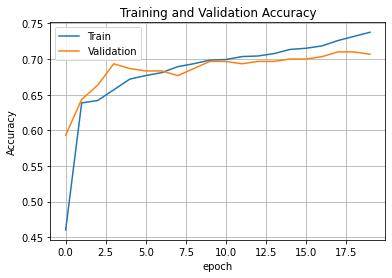

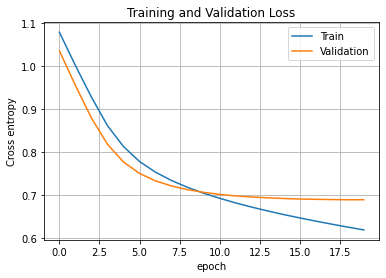

In [ ]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()